In [1]:
import pandas as pd
from pathlib import Path
import duckdb
from graphviz import Source
from scipy.io import loadmat
import sys
from pathlib import Path

sys.path.append(Path.cwd().parent.as_posix())

In [4]:
sys.path

['/Users/erdemkarakoylu/miniconda3/envs/sharp/lib/python312.zip',
 '/Users/erdemkarakoylu/miniconda3/envs/sharp/lib/python3.12',
 '/Users/erdemkarakoylu/miniconda3/envs/sharp/lib/python3.12/lib-dynload',
 '',
 '/Users/erdemkarakoylu/miniconda3/envs/sharp/lib/python3.12/site-packages',
 PosixPath('/Users/erdemkarakoylu/projex/bayesian_quenching'),
 '/Users/erdemkarakoylu/projex/bayesian_quenching']

In [3]:
data_path = Path.cwd().parent / 'data'
ctd_data_path = data_path / 'edi.1396.3_tahoe_ctd_data'
fluo_data_path = data_path / 'edi.1777.1_fluo_data'
met_data = data_path / 'meteorological'

In [4]:
ctd_data_path.exists(), fluo_data_path.exists()

(True, True)

In [ ]:
csv_files = 

| Variable       | Meaning                       |
| -------------- | ----------------------------- |
| $F_m$          | Measured fluorescence (RFU)   |
| $F_r$          | Temp-corrected fluorescence   |
| $T_m$          | Water temperature             |
| $T_r$          | Reference temp (20 °C)        |
| $a$            | NPQ correction scalar         |
| $I_0$          | Incoming shortwave radiation  |
| $k_e$          | Light attenuation coefficient |
| $z$            | Sensor depth                  |
| $\text{Chl}_a$ | Uncorrected Chl *a*           |


In [14]:
data_flow_dag = """
digraph NPQ_Correction_Pipeline {
    rankdir=TB;
    node [shape=box, style=rounded];

    // Available data (blue)
    RFU           [label="F_m: Raw RFU (Fluorometer)", style=filled, fillcolor=lightblue];
    Temp          [label="T_m: Water Temperature (°C)", style=filled, fillcolor=lightblue];
    Depth         [label="z: Sensor Depth (m)", style=filled, fillcolor=lightblue];
    ScalarA       [label="a: NPQ Scalar (fit empirically)", style=filled, fillcolor=lightblue];

    // Missing data (orange)
    Shortwave     [label="I_0: Incoming Shortwave Radiation", style=filled, fillcolor=wheat];
    Secchi        [label="Secchi Depth (for k_e)", style=filled, fillcolor=wheat];

    // Derived steps (gray)
    TempCorr      [label="F_r = F_m / (1 + rho * (T_m - T_r))", style=filled, fillcolor=lightgray];
    RFUConv       [label="log10(Chl_a) = m * log10(F_r) + b", style=filled, fillcolor=lightgray];
    ChlAUncorr    [label="Uncorrected Chl_a", style=filled, fillcolor=lightgray];
    KeCalc        [label="k_e = 1.8 / Secchi", style=filled, fillcolor=lightgray];
    PARCalc       [label="PAR(z) = 0.47 * I_0 * exp(-k_e * z)", style=filled, fillcolor=lightgray];
    ChlACorrected [label="Chl_a_corrected = Chl_a * exp(a * PAR)", style=filled, fillcolor=lightgray];

    // Edges
    RFU -> TempCorr;
    Temp -> TempCorr;
    TempCorr -> RFUConv;
    RFU -> RFUConv;
    RFUConv -> ChlAUncorr;

    Shortwave -> PARCalc;
    Secchi -> KeCalc;
    KeCalc -> PARCalc;
    Depth -> PARCalc;

    PARCalc -> ChlACorrected;
    ChlAUncorr -> ChlACorrected;
    ScalarA -> ChlACorrected;
}
"""

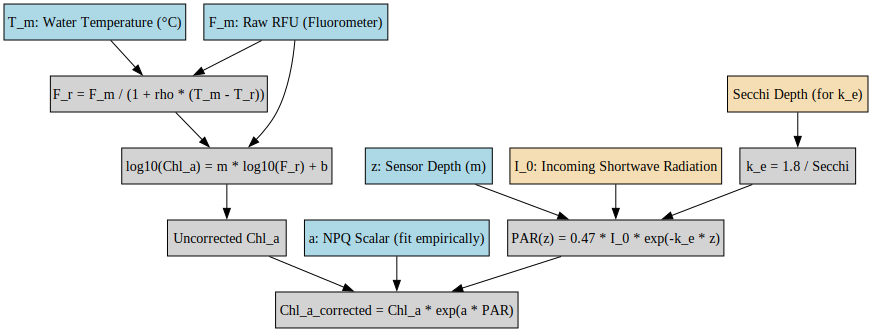

In [16]:
Source(data_flow_dag)

In [15]:
Source(data_flow_dag).render("npq_dag", format="png", view=True)

'npq_dag.png'

We developed NPQ correction models for each <u>site-specific</u>, <u>instrument-specific</u>, 
and <u>date-specific</u> dataset. We then determined a universal NPQ correction model as a log-linear
relationship (Eq. 5) between the average Chl a concentration ($\overline{chla}$) for each dataset and 
the scalar factor from Eq. 4 determined for each dataset's NPQ correction model.

In [17]:
fluo_files= list(fluo_data_path.glob('*.csv'))

In [18]:
fluo_files

[PosixPath('/Users/erdemkarakoylu/projex/bayesian_quenching/data/edi.1777.1_fluo_data/SeaHAB_ClearLake_20220707.csv'),
 PosixPath('/Users/erdemkarakoylu/projex/bayesian_quenching/data/edi.1777.1_fluo_data/BBFL2W_Tahoe_20210819.csv'),
 PosixPath('/Users/erdemkarakoylu/projex/bayesian_quenching/data/edi.1777.1_fluo_data/SBE25_ClearLake_20220707.csv'),
 PosixPath('/Users/erdemkarakoylu/projex/bayesian_quenching/data/edi.1777.1_fluo_data/YSI_Tahoe_20221005.csv'),
 PosixPath('/Users/erdemkarakoylu/projex/bayesian_quenching/data/edi.1777.1_fluo_data/BBFL2W_ClearLake_20220707.csv'),
 PosixPath('/Users/erdemkarakoylu/projex/bayesian_quenching/data/edi.1777.1_fluo_data/FLNTU_ClearLake_20220707.csv'),
 PosixPath('/Users/erdemkarakoylu/projex/bayesian_quenching/data/edi.1777.1_fluo_data/SBE25_Tahoe_20221005.csv'),
 PosixPath('/Users/erdemkarakoylu/projex/bayesian_quenching/data/edi.1777.1_fluo_data/NS_Tahoe_20160825.csv'),
 PosixPath('/Users/erdemkarakoylu/projex/bayesian_quenching/data/edi.1777.

In [33]:
df = pd.read_csv(fluo_files[0], parse_dates=[0])
file_name = fluo_files[0].stem
instrument_name, lake_name, _ = file_name.split('_')
df['instrument_name'] = instrument_name
df['lake_name'] = lake_name
df = df[['Time_local', 'lake_name', 'instrument_name', 'Chla_ugL']]

In [41]:
df_

,Time_local,Chla_ugL,instrument_name
0,2022-07-07 04:03:00,19.835761,SeaHAB
1,2022-07-07 04:05:00,19.641403,SeaHAB
2,2022-07-07 04:07:00,19.145554,SeaHAB
3,2022-07-07 04:09:00,16.562635,SeaHAB
4,2022-07-07 04:11:00,18.428817,SeaHAB
...,...,...,...
514,2022-07-07 22:16:00,19.875923,SeaHAB
515,2022-07-07 22:18:00,20.684214,SeaHAB
516,2022-07-07 22:20:00,22.715181,SeaHAB
517,2022-07-07 22:22:00,19.425078,SeaHAB


In [59]:
df = pd.DataFrame(columns=['Time_local', 'lake_name', 'instrument_name', 'Chla_ugL'])
for fn in fluo_files[:2]:
    df_ = pd.read_csv(fn, parse_dates=[0])
    fn_stem = fn.stem
    instrument_name, lake_name, _ = file_name.split('_')
    df_['instrument_name'], df_['lake_name'] = instrument_name, lake_name
    df_ = df_[['Time_local', 'lake_name', 'instrument_name', 'Chla_ugL']]
    df= pd.concat((df, df_), axis=0)


/var/folders/c9/p_x94m2j357984db558g2n9m0000gn/T/ipykernel_12874/2106470321.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df= pd.concat((df, df_), axis=0)


In [60]:
df.head()


,Time_local,lake_name,instrument_name,Chla_ugL
0,2022-07-07 04:03:00,ClearLake,SeaHAB,19.835761
1,2022-07-07 04:05:00,ClearLake,SeaHAB,19.641403
2,2022-07-07 04:07:00,ClearLake,SeaHAB,19.145554
3,2022-07-07 04:09:00,ClearLake,SeaHAB,16.562635
4,2022-07-07 04:11:00,ClearLake,SeaHAB,18.428817


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1033 entries, 0 to 513
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Time_local       1033 non-null   datetime64[ns]
 1   lake_name        1033 non-null   object        
 2   instrument_name  1033 non-null   object        
 3   Chla_ugL         1033 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 40.4+ KB


In [62]:
df.instrument_name.value_counts()

instrument_name
SeaHAB    1033
Name: count, dtype: int64

## Meteorological Data

In [7]:
met_data = Path.cwd().parent / 'data' / 'meteorological'
met_data.exists()

MATLAB_FILE_PATH = met_data / 'PAR_Tahoe.mat'

In [8]:
met_data_payload = list(met_data.glob('*.mat'))

In [6]:
met_data_payload

[PosixPath('/Users/erdemkarakoylu/projex/bayesian_quenching/data/meteorological/ClearLake_met_data_202108.mat'),
 PosixPath('/Users/erdemkarakoylu/projex/bayesian_quenching/data/meteorological/Tahoe_met_data_202210.mat'),
 PosixPath('/Users/erdemkarakoylu/projex/bayesian_quenching/data/meteorological/PAR_Tahoe.mat'),
 PosixPath('/Users/erdemkarakoylu/projex/bayesian_quenching/data/meteorological/PAR_Tahoe2016.mat'),
 PosixPath('/Users/erdemkarakoylu/projex/bayesian_quenching/data/meteorological/USCG_MetData_2016.mat'),
 PosixPath('/Users/erdemkarakoylu/projex/bayesian_quenching/data/meteorological/ClearLake_met_data_202207.mat'),
 PosixPath('/Users/erdemkarakoylu/projex/bayesian_quenching/data/meteorological/Tahoe_met_data_202108.mat'),
 PosixPath('/Users/erdemkarakoylu/projex/bayesian_quenching/data/meteorological/PAR_ClearLake.mat')]

In [7]:
clear_lake = loadmat(met_data / 'ClearLake_met_data_202108.mat')

In [9]:
clear_lake

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Sep  6 15:46:49 2022',
 '__version__': '1.0',
 '__globals__': [],
 'met_data': array([[(array([[737506.70833333],
                [737506.75      ],
                [737506.79166667],
                ...,
                [738757.9375    ],
                [738757.94791667],
                [738757.95833333]]), array([[ 35.],
                [ 69.],
                [ 71.],
                ...,
                [678.],
                [647.],
                [612.]]))                          ]],
       dtype=[('time', 'O'), ('SW', 'O')])}

In [15]:
par_tahoe = loadmat(met_data / 'PAR_Tahoe.mat')

In [23]:
par_tahoe['PAR_Tahoe'][0,0]

(array([[  0.        ],
       [  0.        ],
       [  0.        ],
       [  0.        ],
       [  0.        ],
       [  0.        ],
       [  0.        ],
       [  0.        ],
       [  0.        ],
       [  0.        ],
       [  0.        ],
       [  0.        ],
       [  0.        ],
       [  1.85632873],
       [ 11.62021824],
       [ 31.27786762],
       [ 47.22558409],
       [ 64.66272283],
       [ 80.60135746],
       [ 95.81344465],
       [110.70766732],
       [126.23761901],
       [141.4497062 ],
       [156.34392887],
       [171.14733311],
       [185.81450971],
       [199.80054808],
       [214.05904174],
       [227.77262481],
       [241.07752494],
       [253.88292371],
       [266.09800267],
       [277.54112497],
       [288.25769982],
       [298.20231801],
       [307.55661639],
       [315.82109361],
       [323.44984181],
       [330.35204256],
       [336.346059  ],
       [340.93238977],
       [345.65494817],
       [349.28768541],
       [35

In [12]:
from datetime import datetime, timedelta
import numpy as np
import pandas as pd

def extract_par_struct(mat_data, struct_name="PAR_Tahoe"):
    """
    Extract the PAR structure from the loaded MATLAB data.

    Parameters
    ----------
    mat_data : dict
        Dictionary loaded from the MATLAB file.
    struct_name : str
        Name of the struct containing PAR data.

    Returns
    -------
    dict
        Dictionary with keys 'PAR' and 'datenum' extracted from the structure.
    """
    struct = mat_data[struct_name][0, 0]
    par_array = struct['PAR'].squeeze()
    print(f"Struct fields: {list(struct.dtype.fields.keys())}")
    if 'datenum' not in struct.dtype.fields:
        raise KeyError(f"'datenum' field not found in the struct '{struct_name}'")
            
    # Squeeze to remove any singleton dimensions
    if isinstance(struct['datenum'], np.ndarray) and struct['datenum'].ndim > 1:
        struct['datenum'] = struct['datenum'].squeeze()
    datenum_array = struct['datenum'].squeeze()
    if not isinstance(par_array, np.ndarray):
        raise TypeError(f"'PAR' field in struct '{struct_name}' is not a numpy array")
    if not isinstance(datenum_array, np.ndarray):
        raise TypeError(f"'datenum' field in struct '{struct_name}' is not a numpy array")
    
    # Ensure both arrays are 1D 
    return {'PAR': par_array, 'datenum': datenum_array}


def datenum_to_datetime(datenum_array):
    """
    Convert a numpy array of MATLAB datenum values to Python datetime objects.

    MATLAB datenum is defined as:
        days since Jan 0, 0000

    Python's datetime.fromordinal uses:
        days since Jan 1, 0001

    Parameters
    ----------
    datenum_array : array-like of float
        MATLAB datenum values.

    Returns
    -------
    list of datetime
        Corresponding Python datetime objects.
    """
    return [
        datetime.fromordinal(int(dn)) + timedelta(days=dn % 1) - timedelta(days=366)
        for dn in datenum_array
    ]


def create_par_dataframe(par_array, datetime_array):
    """
    Create a pandas DataFrame from PAR values and datetime objects.

    Parameters
    ----------
    par_array : array-like of float
        PAR measurements.
    datetime_array : list of datetime
        Corresponding datetime stamps.

    Returns
    -------
    pandas.DataFrame
        DataFrame with 'datetime' and 'PAR' columns.
    """
    return pd.DataFrame({
        "datetime": datetime_array,
        "PAR": par_array
    })

In [9]:
MATLAB_FILE_PATH = met_data / 'PAR_Tahoe.mat'

In [17]:
mfp = met_data / 'Tahoe_met_data_202108.mat'

In [15]:
import mat73

In [18]:
data = mat73.loadmat(mfp)

TypeError: /Users/erdemkarakoylu/projex/bayesian_quenching/data/meteorological/Tahoe_met_data_202108.mat is not a MATLAB 7.3 file. Load with scipy.io.loadmat() instead.

In [22]:
import hdf5storage

data = hdf5storage.loadmat(MATLAB_FILE_PATH)

In [24]:
data['PAR_Tahoe']

array([[(array([[  0.        ],
               [  0.        ],
               [  0.        ],
               [  0.        ],
               [  0.        ],
               [  0.        ],
               [  0.        ],
               [  0.        ],
               [  0.        ],
               [  0.        ],
               [  0.        ],
               [  0.        ],
               [  0.        ],
               [  1.85632873],
               [ 11.62021824],
               [ 31.27786762],
               [ 47.22558409],
               [ 64.66272283],
               [ 80.60135746],
               [ 95.81344465],
               [110.70766732],
               [126.23761901],
               [141.4497062 ],
               [156.34392887],
               [171.14733311],
               [185.81450971],
               [199.80054808],
               [214.05904174],
               [227.77262481],
               [241.07752494],
               [253.88292371],
               [266.09800267],
       

In [25]:
data = loadmat(MATLAB_FILE_PATH,squeeze_me=True,struct_as_record=False)

In [34]:
pip install mat4py

Note: you may need to restart the kernel to use updated packages.


In [38]:
pip uninstall mat4py -y

Found existing installation: mat4py 0.6.0
Uninstalling mat4py-0.6.0:
  Successfully uninstalled mat4py-0.6.0
Note: you may need to restart the kernel to use updated packages.


In [ ]:
data['PAR_Tahoe'].time.dump(met_data /'time', )

In [13]:
mat_data = loadmat(met_data / 'PAR_Tahoe.mat')
par_data = extract_par_struct(mat_data)
datetime_array = datenum_to_datetime(par_data['datenum'])
par_df = create_par_dataframe(par_data['PAR'], datetime_array)

par_df.head()

par_df.info()

par_df.to_csv(met_data / 'PAR_Tahoe.csv', index=False)
par_df.to_parquet(met_data / 'PAR_Tahoe.parquet', index=False)

Struct fields: ['PAR', 'time']


KeyError: "'datenum' field not found in the struct 'PAR_Tahoe'"

In [ ]:
# Load .mat file
#mat_data = load_mat_file(MATLAB_FILE_PATH)

# Extract struct contents
par_struct = extract_par_struct(mat_data)

# Convert datenum to datetime
datetime_list = datenum_to_datetime(par_struct['datenum'])

# Create final DataFrame
df_par = create_par_dataframe(par_struct['PAR'], datetime_list)

# Expose df_par for downstream use if needed
df_par.head()